# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.ml import pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

# Part 2. Unsupervised learning

I would recommend to follow the notebook `unsupervised_learning.ipynb` first, shared through the IST 718 repository.

The following dataset contains information about Spotify songs.

In [2]:
spotify_df = spark.read.csv('/datasets/spotify_songs.csv',
                            inferSchema=True, header=True).\
                     orderBy(['song_title', 'artist'])

# Question 1: (10 pts) 

Create a fitted pipeline `pipe_pca` that takes the features `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `key`, `liveness`, `loudness`, `mode`, `speechiness`, `tempo`, `time_signature`, and `valence` (in that order), 2) standardize them, and 3) compute the two first principal components. The pipeline should produce a column `pc` which contains these components.

Create a dataframe `spotify_pc_df` with all columns of `spotify_df`, in the same order, and the column `pc`.

In [3]:
# create the pipe_pca PipelineModel below (10 pts)
# YOUR CODE HERE
pipe_pca= Pipeline(stages=[
          feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                                             'liveness', 'loudness','mode', 'speechiness', 'tempo','time_signature', 'valence'],
                                 outputCol='features'),
           feature.StandardScaler(withMean=True,inputCol='features',outputCol='zfeatures'),
            feature.PCA(k=2,inputCol='zfeatures',outputCol='pc')]).fit(spotify_df)

spotify_pc_df=pipe_pca.transform(spotify_df).select('acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                                             'liveness', 'loudness','mode', 'speechiness', 'tempo','time_signature', 'valence','pc')

#raise NotImplementedError()

In [4]:
# Tests for (10 pts)
np.testing.assert_equal(type(pipe_pca),  pipeline.PipelineModel)
np.testing.assert_equal(set(spotify_pc_df.columns), {'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence', 'pc'})
np.testing.assert_equal(spotify_pc_df.first().pc.shape, (2, ))

# Question 2: (10 pts)

Create a scatter plot with the x axis containing the first principal component and the y axis containing the second principal component of `ds_features_df`

In [5]:
principal_components = pipe_pca.stages[-1].pc.toArray()

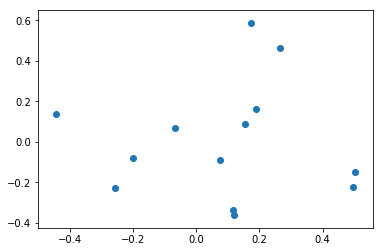

In [6]:
# below perform the appropriate 
# YOUR CODE HERE
principal_components = pipe_pca.stages[-1].pc.toArray()
x=list(zip(['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence'], 
         principal_components[:, 0], principal_components[:, 1]))
ds_features_df=pd.DataFrame(x).rename(columns={0: 'features', 1: 'pc1',2: 'pc2',})
ds_features_df
plt.scatter(ds_features_df.pc1, ds_features_df.pc2)
#

#raise NotImplementedError()

In [7]:
ds_features_df

,features,pc1,pc2
0,acousticness,-0.442305,0.139134
1,danceability,0.172181,0.586402
2,duration_ms,-0.201088,-0.080908
3,energy,0.496684,-0.225463
4,instrumentalness,-0.255942,-0.226391
5,key,0.074194,-0.088999
6,liveness,0.121120,-0.362308
7,loudness,0.503430,-0.147281
8,mode,-0.066402,0.069554
9,speechiness,0.156085,0.085936


# Question 3 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `feature` and `abs_loading` that contain the top 3 features in absolute loading for the principal components 1 and 2, respetively.

In [8]:
# YOUR CODE HERE
pc1_pd=ds_features_df.sort_values('pc1').\
    apply({'features': lambda x: x, 'pc1': np.abs}, axis=0).head(3)
pc1_pd.columns=['feature','abs_loading']
pc2_pd=ds_features_df.sort_values('pc2').\
    apply({'features': lambda x: x, 'pc2': np.abs}, axis=0).head(3)
pc2_pd.columns=['feature','abs_loading']
#raise NotImplementedError()

In [9]:
# (10 pts)
assert type(pc1_pd) == pd.core.frame.DataFrame
assert type(pc2_pd) == pd.core.frame.DataFrame
np.testing.assert_array_equal(pc1_pd.shape, (3, 2))
np.testing.assert_array_equal(pc2_pd.shape, (3, 2))
np.testing.assert_equal(set(pc1_pd.columns), {'abs_loading', 'feature'})
np.testing.assert_equal(set(pc2_pd.columns), {'abs_loading', 'feature'})

# Question 4: (10 pts)

Similar to question 1, create a new pipeline for PCA called `pipe_pca2` where you fit 10 principal components instead of the 3 above. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable `explainedVariance` the variance explained by components of such model. Finally, assign to a variable `best_k` the value $k$ such that the ($k+1$)-th component explains less than 0.01 variance. You can use a for-loop to find such best k.

In [18]:
# YOUR CODE HERE
pipe_pca2= Pipeline(stages=[
          feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                                             'liveness', 'loudness','mode', 'speechiness', 'tempo','time_signature', 'valence'],
                                 outputCol='features'),
           feature.StandardScaler(withStd = True , withMean=True,inputCol='features',outputCol='zfeatures'),
            feature.PCA(k=10,inputCol='zfeatures',outputCol='pc')]).fit(spotify_df)

explainedVariance = pipe_pca2.stages[2].explainedVariance
k=1
for i in range(len(explainedVariance)):
    if explainedVariance[i] < 0.01:
        k=k+1
    else:
        break
best_k = k

#raise NotImplementedError()

In [11]:
best_k

1

In [19]:
explainedVariance

DenseVector([0.2191, 0.1176, 0.101, 0.0866, 0.0793, 0.0746, 0.069, 0.0612, 0.0577, 0.0504])

In [13]:
# Tests (10 pts)
np.testing.assert_equal(type(pipe_pca2.stages[-1]),  feature.PCAModel)
np.testing.assert_equal(len(explainedVariance), 10)

# Question 5 (10 pts)

Perform k-means on the features (not standardized) of the Spotify dataset with k = 5. Do this by creating a fitted pipeline `pipe_kmeans` that produces a column `cluster` with the cluster membership number of a song. Create a second fitted pipeline `pipe_analysis` that combines both `pipe_pca` and `pipe_kmeans` and fit it to the data. Finally, create a dataframe `spotify_features_df` that contains as columns the principal components `pc` and the cluster membership `cluster`. **Note**: Make sure to not create naming conflicts between the standardized features created by `pipe_pca` and the non-standardized features created by `pipe_kmeans`.

In [14]:
# YOUR CODE HERE
pipe_kmeans=Pipeline(stages=[
          feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                                             'liveness', 'loudness','mode', 'speechiness', 'tempo','time_signature', 'valence'],
                                 outputCol='myfeatures'),
            clustering.KMeans(k=5,featuresCol='myfeatures',predictionCol='cluster')]).fit(spotify_df)
pipe_analysis=Pipeline(stages=[pipe_pca,pipe_kmeans]).fit(spotify_df)
spotify_features=pipe_analysis.transform(spotify_df).select('pc','cluster')
#raise NotImplementedError()

In [15]:
spotify_features.show()

+--------------------+-------+
|                  pc|cluster|
+--------------------+-------+
|[-0.8685751996998...|      0|
|[0.73713355270429...|      3|
|[-0.3714796389780...|      4|
|[-4.2090287897294...|      0|
|[-0.3838592531849...|      3|
|[0.53124151282219...|      0|
|[-5.0208615795793...|      1|
|[-6.1461450280705...|      3|
|[-0.4130577070259...|      4|
|[0.74799295095914...|      4|
|[0.58637862964117...|      1|
|[0.87023711530836...|      1|
|[-0.1506327073122...|      4|
|[-1.7117946522045...|      3|
|[2.00695995578768...|      4|
|[1.23802220189129...|      0|
|[0.22470623652492...|      1|
|[-1.0587481803838...|      0|
|[-1.0861712511244...|      0|
|[-0.4747387906461...|      0|
+--------------------+-------+
only showing top 20 rows



In [16]:
# Tests for (10 pts)
np.testing.assert_equal(type(pipe_kmeans),  pipeline.PipelineModel)
np.testing.assert_equal(type(pipe_analysis),  pipeline.PipelineModel)
np.testing.assert_equal(set(spotify_features.columns), {'pc', 'cluster'})
np.testing.assert_equal(spotify_features.first().pc.shape, (2, ))
np.testing.assert_equal(type(spotify_features.first().cluster), int)
### BEGIN HDIDEN TESTS
np.testing.assert_array_equal(len(pipe_kmeans.stages), 2)

**10 pts**: Below, create a plot with the x axis being the first principal component and y-axis being the second principal component, using `spotify_features`. Set the color of each song with the cluster number.

Text(0,0.5,'pc2')

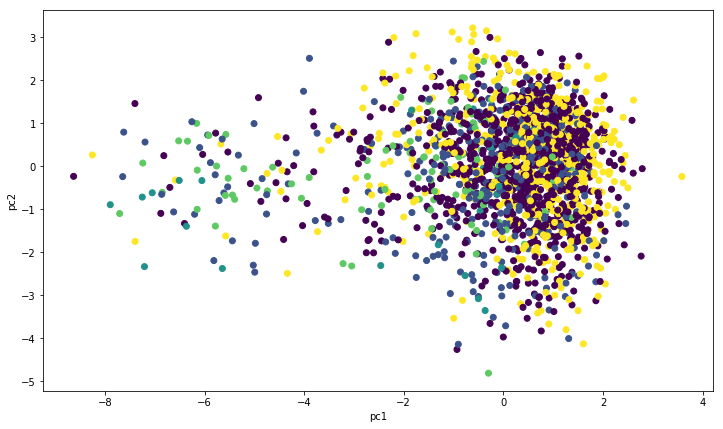

In [17]:
# YOUR CODE HERE
def extract(row):
    return tuple(row.pc.toArray().tolist())+ (row.cluster, )
x=spotify_features.rdd.map(extract).toDF(["x"]) 
final_spotify_features = x.selectExpr( "x as pc1",'_2 as pc2',"_3 as cluster",)
pdf1=final_spotify_features.toPandas()

plt.figure(figsize=(12,7))
plt.scatter(pdf1.pc1, pdf1.pc2, c=pdf1.cluster)
plt.xlabel('pc1')
plt.ylabel('pc2')

#raise NotImplementedError()